In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('winequality-white.csv')
features = df.drop('quality',axis=1).columns

In [3]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# 1

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['quality'],axis=1),
                                                    df['quality'], test_size=0.3, random_state=0)


In [5]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='r2')

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, scoring='r2', verbose=2)

# 2

In [12]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_random, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

alcohol 0.275 +/- 0.013
volatile acidity0.128 +/- 0.007
free sulfur dioxide0.089 +/- 0.008
density 0.084 +/- 0.007
residual sugar0.053 +/- 0.004
total sulfur dioxide0.052 +/- 0.004
chlorides0.047 +/- 0.005
pH      0.046 +/- 0.005
citric acid0.040 +/- 0.003
fixed acidity0.022 +/- 0.003
sulphates0.019 +/- 0.003


As we can see, from the above results, we have ranked the features based on permutation importance.

In [13]:
!pip install SHAP

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


# 3

In [61]:
import shap
explainer = shap.Explainer(rf_random.best_estimator_)
shap_values = explainer(X_train)

In [62]:
X_train_summary = shap.kmeans(X_train, 10)

In [42]:
shap_values[sample_ind:sample_ind+1,:]

.values =
array([[-0.01781898, -0.42517908, -0.10514338, -0.16169169, -0.16768236,
         0.01364939, -0.02187031,  0.03414484, -0.08240121, -0.06238443,
         0.11407676]])

.base_values =
array([[5.89731622]])

.data =
array([[6.6000e+00, 7.8000e-01, 5.0000e-01, 1.5000e+00, 4.5000e-02,
        3.0000e+01, 1.3300e+02, 9.9104e-01, 3.2500e+00, 4.8000e-01,
        1.1700e+01]])

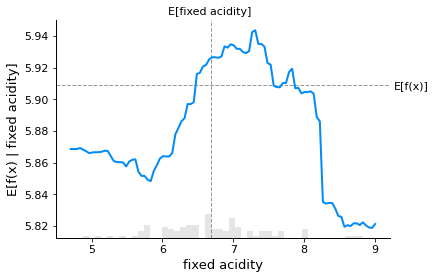

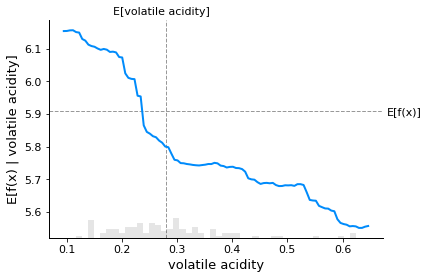

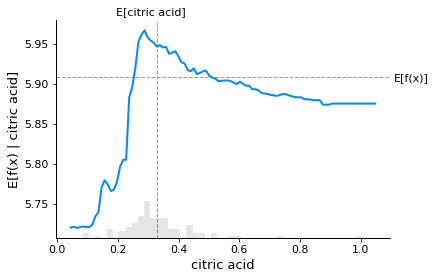

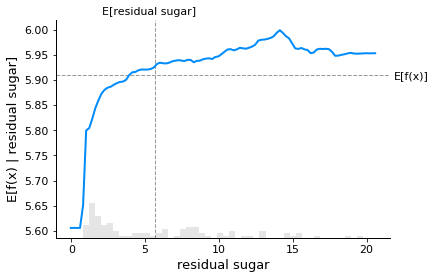

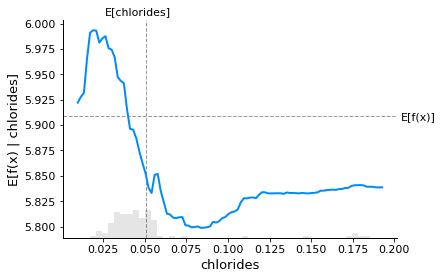

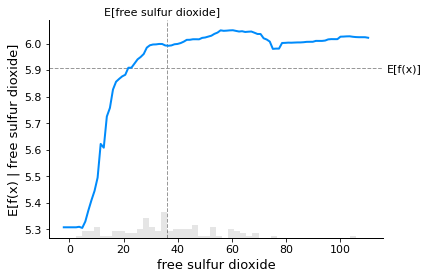

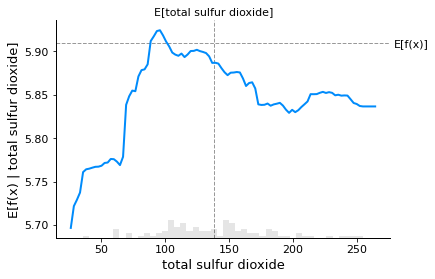

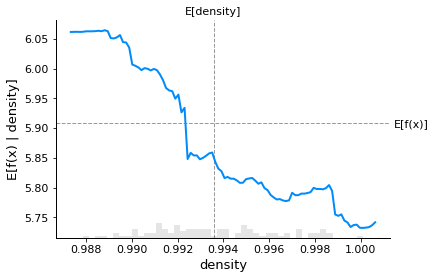

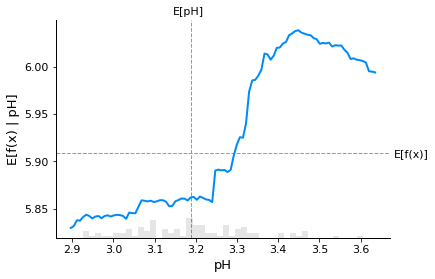

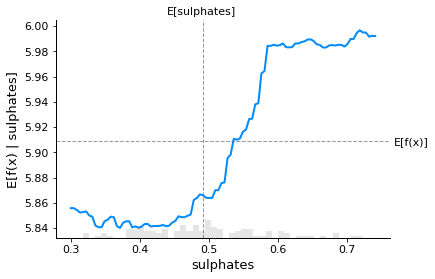

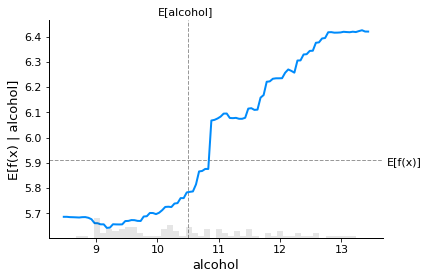

In [71]:
X100 = shap.utils.sample(X_train, 100)
sample_ind = 18
for i in features:
    try:
        shap.partial_dependence_plot(
            i, rf_random.predict, X100, model_expected_value=True,
            feature_expected_value=True, ice=False,
            shap_values=shap_values_1[0:1]
        )
    except:
        x=1

# 4

In [28]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


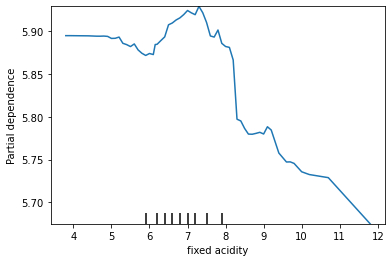

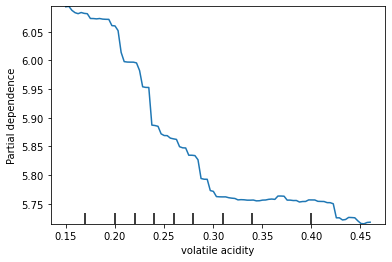

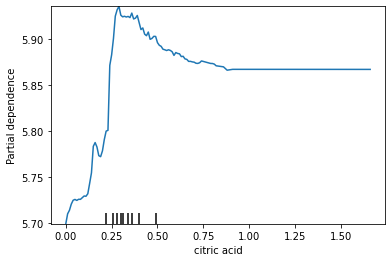

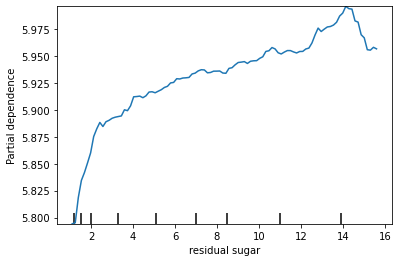

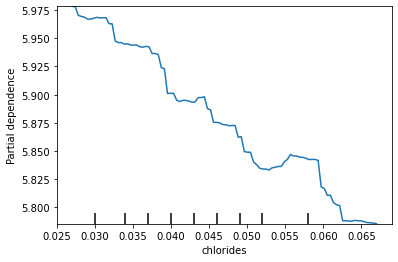

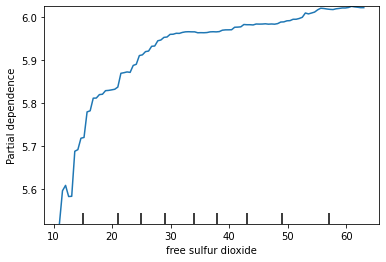

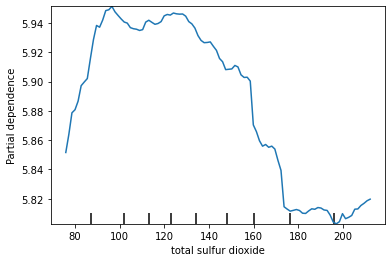

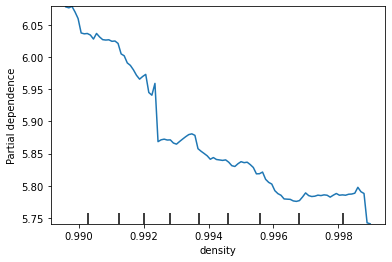

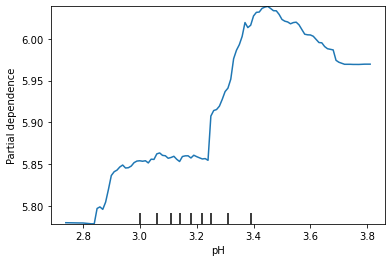

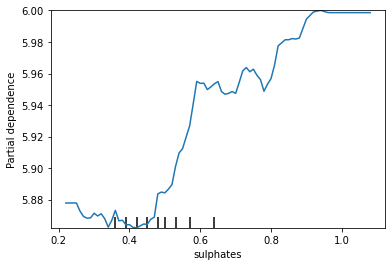

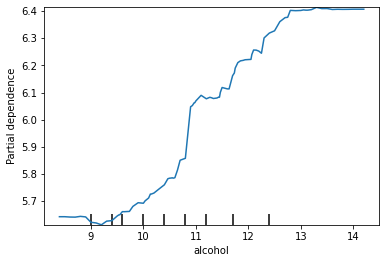

In [18]:
for i in features:
    PartialDependenceDisplay.from_estimator(rf_random, X_train, [i])

# 5

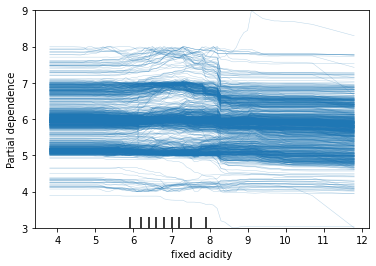

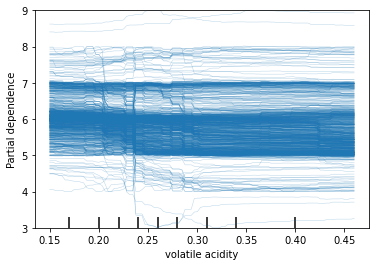

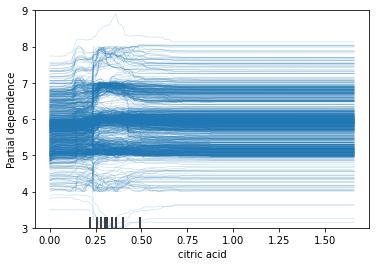

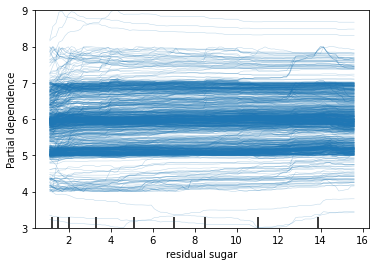

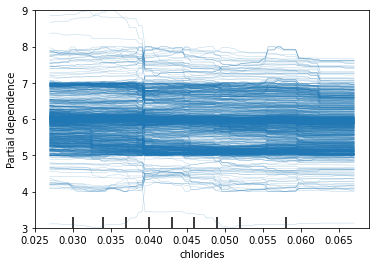

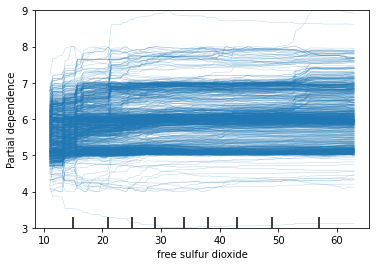

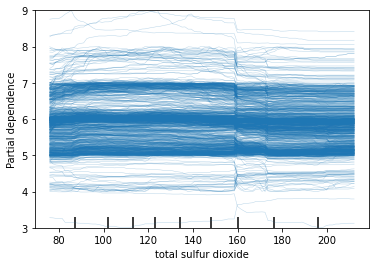

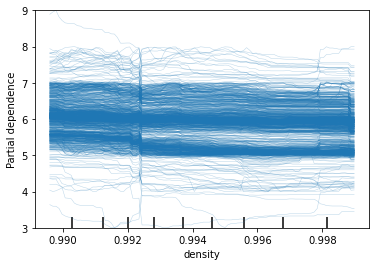

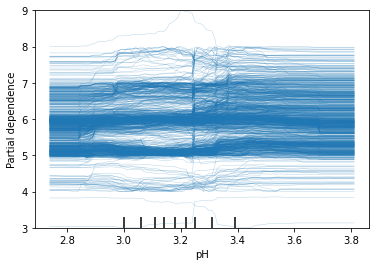

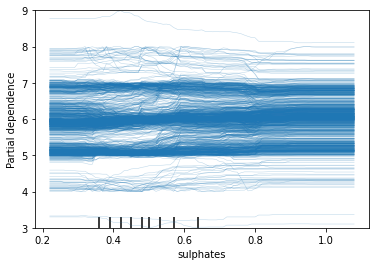

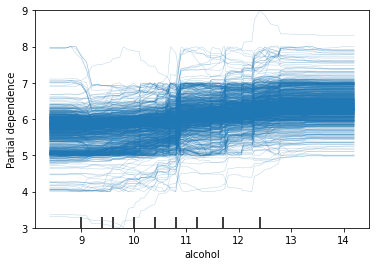

In [13]:
for i in features:
    PartialDependenceDisplay.from_estimator(rf_random, X_train, [i],
    kind='individual')

# 6

Out of all the four techniques, ranking features based on permutation importance, partial dependence plots, ICE plots and SHAP algorithm, I find that the SHAP algoithm was bette.

The model did a good job of predicting the quality of white wine. But how did it come up with such predictions? How much did each feature contribute to the difference between the final prediction and the average prediction?

That is why finding the Shapley value of each feature can help us determine their contribution. The steps to get the importance of the feature i, where i is the index of features, is similar to before:

Because we get all subsets that don’t contain the feature i, find the marginal contribution of the feature i to each of these subsets and aggregate all marginal contributions to compute the contributions of the feature I